# Synthetic Log Generation: Missing Sonic Log Prediction
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Petrophysics & Static Modeling

**Objective:**
Predict missing Sonic (DT) logs using Gamma Ray (GR), Deep Resistivity (ILD), and Depth as input features.

**Algorithm:**
We will use **XGBoost (Extreme Gradient Boosting)**, a powerful ensemble learning method that is highly effective for non-linear petrophysical relationships.

**Workflow:**
1.  **Data Loading:** Import well log data.
2.  **Exploratory Data Analysis (EDA):** Visualize log correlations (GR vs. DT).
3.  **Preprocessing:** Handle missing values and normalize data if necessary.
4.  **Model Training:** Train an XGBoost Regressor.
5.  **Evaluation:** Metrics (RMSE, $R^2$) and Blind Test visualization.

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries Imported Successfully")

Libraries Imported Successfully


## 2. Load Data and Exploratory Data Analysis (EDA)

We will load the dataset and perform a quick quality check. We need to ensure that the relationship between `GR` (Lithology) and `DT` (Porosity/Velocity) exists.

             DEPTH            GR           ILD            DT
count  25000.00000  25000.000000  25000.000000  25000.000000
mean    7249.75000     65.219732      9.214352     75.216197
std     3608.51135     37.161293     20.874879     19.167721
min     1000.00000     10.000000      0.291859     36.940559
25%     4124.87500     30.075702      2.023393     57.634942
50%     7249.75000     61.763928      2.911093     73.432908
75%    10374.62500     99.928668      4.447610     92.714460
max    13499.50000    155.917500    329.813590    126.979178


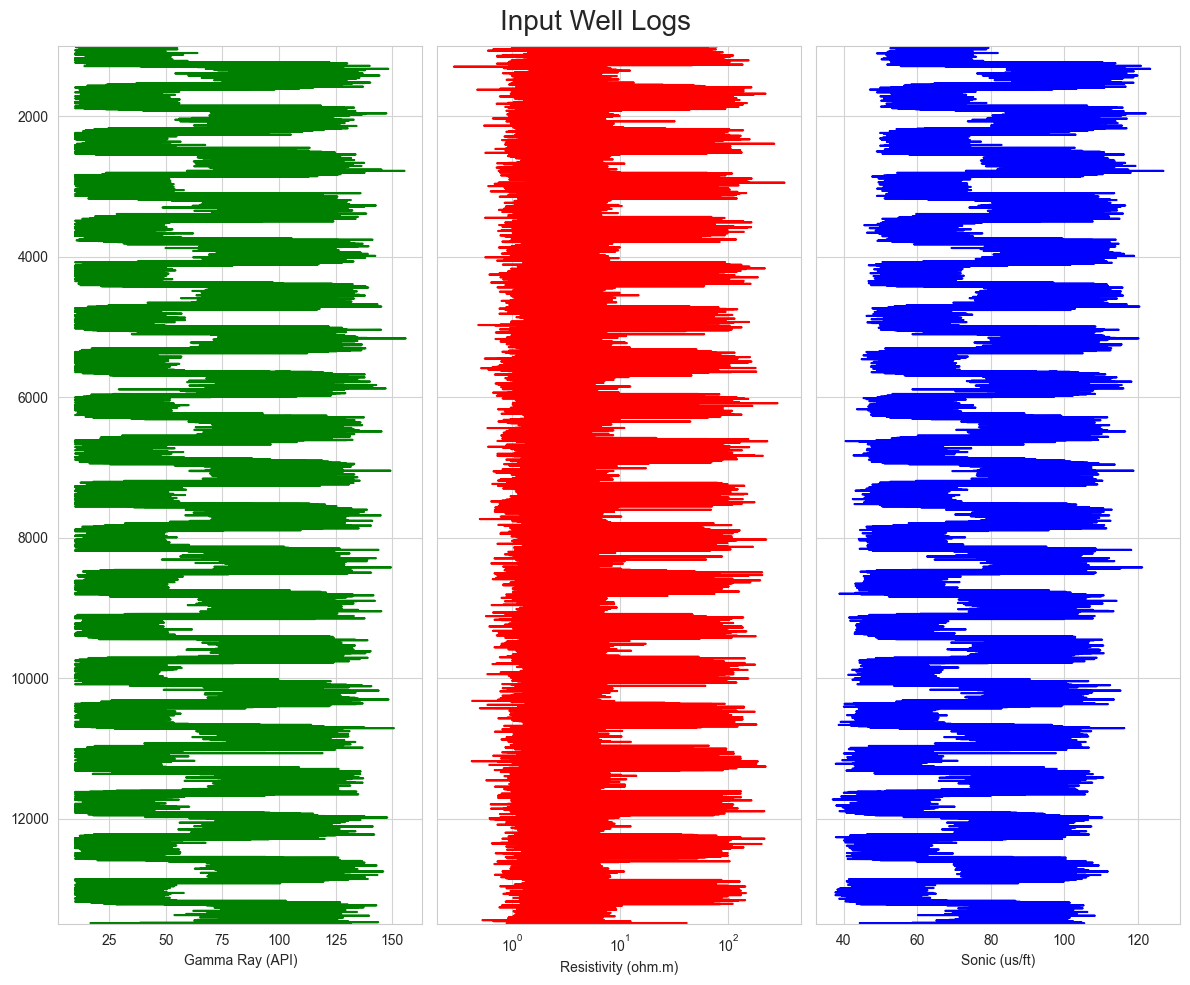

In [2]:
# Load dataset
df = pd.read_csv('well_logs.csv')

# Display basic stats
print(df.describe())

# Visualizing the Logs (Triple Combo style)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,10), sharey=True)
fig.suptitle("Input Well Logs", fontsize=20)

# Track 1: Gamma Ray
ax[0].plot(df['GR'], df['DEPTH'], color='green')
ax[0].set_xlabel("Gamma Ray (API)")
ax[0].set_ylim(max(df['DEPTH']), min(df['DEPTH'])) # Invert Depth
ax[0].grid(which='major', color='lightgrey', linestyle='-')

# Track 2: Resistivity (Log Scale)
ax[1].semilogx(df['ILD'], df['DEPTH'], color='red')
ax[1].set_xlabel("Resistivity (ohm.m)")
ax[1].grid(which='major', color='lightgrey', linestyle='-')

# Track 3: Sonic (Target)
ax[2].plot(df['DT'], df['DEPTH'], color='blue')
ax[2].set_xlabel("Sonic (us/ft)")
ax[2].grid(which='major', color='lightgrey', linestyle='-')

plt.tight_layout()
plt.show()

### Correlation Matrix
Understanding feature correlation is vital. In petrophysics:
* **GR vs DT:** Usually positive correlation (Shale = High GR = High DT/Slow).
* **ILD vs DT:** Often negative correlation (Tight rock/Compacted = High ILD = Low DT/Fast).

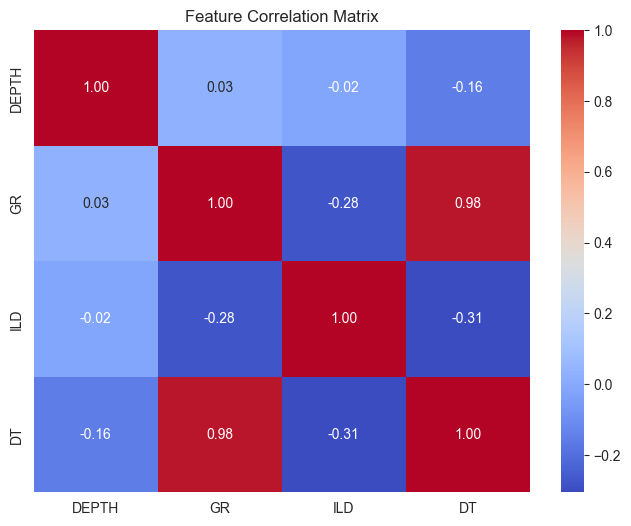

In [3]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

## 3. Data Preparation

We will split the data into Training and Testing sets.
* **Inputs (X):** DEPTH, GR, ILD
* **Target (y):** DT

*Note: Resistivity is often log-distributed. It is often beneficial to feed the log10 of Resistivity into the model, though tree-based models like XGBoost handle raw data reasonably well.*

In [4]:
# Feature Engineering: Add Log10 of Resistivity
df['log_ILD'] = np.log10(df['ILD'])

# Define Features and Target
X = df[['DEPTH', 'GR', 'log_ILD']]
y = df['DT']

# Train/Test Split (80% Train, 20% Test)
# random_state=42 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")

Training Samples: 20000
Testing Samples: 5000


## 4. Model Training (XGBoost)

We instantiate the XGBoost regressor.
* `n_estimators`: Number of boosting rounds (trees).
* `learning_rate`: Step size shrinkage to prevent overfitting.
* `max_depth`: Controls tree complexity.

In [5]:
# Initialize XGBoost Regressor
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    objective='reg:squarederror',
    n_jobs=-1
)

# Train the model
model.fit(X_train, y_train)

print("Model Training Complete.")

Model Training Complete.


## 5. Model Evaluation

We evaluate the performance using **RMSE** (Root Mean Squared Error) and **R2 Score**.
* **RMSE:** Should be low (e.g., < 5 us/ft is usually acceptable for Sonic).
* **R2:** Closer to 1.0 indicates better fit.

Model Performance:
RMSE: 2.05 us/ft
R2 Score: 0.9886


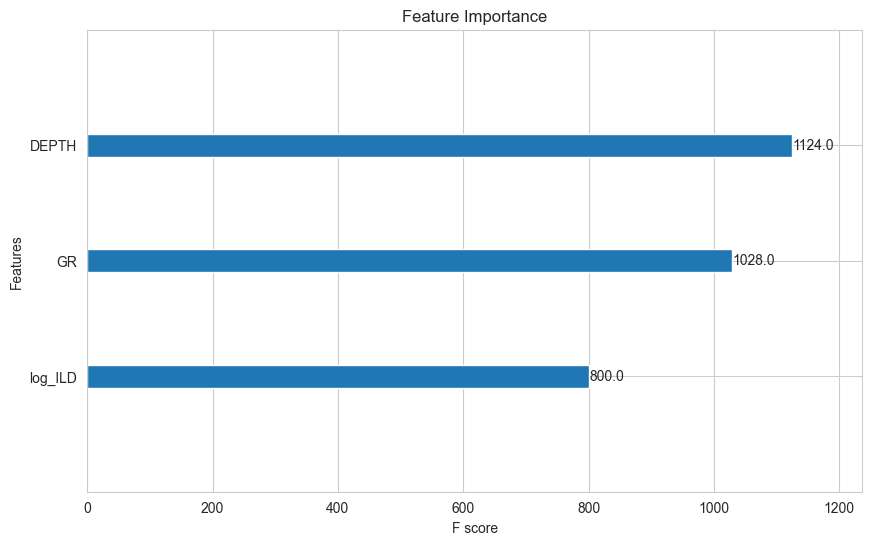

In [6]:
# Predict on Test Set
y_pred = model.predict(X_test)

# Calculate Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"RMSE: {rmse:.2f} us/ft")
print(f"R2 Score: {r2:.4f}")

# Feature Importance
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

## 6. Visualization: Synthetic vs Actual Log

To truly validate a petrophysical model, we must visualize the predicted curve against the actual curve vs Depth. We will take a slice of the test data to visualize.

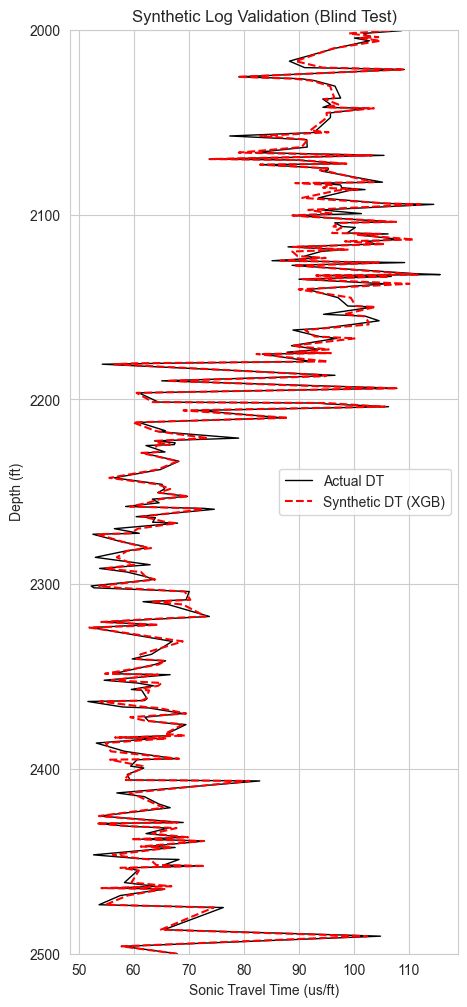

In [7]:
# Create a dataframe for comparison from the test set
comparison_df = X_test.copy()
comparison_df['Actual_DT'] = y_test
comparison_df['Predicted_DT'] = y_pred

# Sort by depth for plotting
comparison_df = comparison_df.sort_values(by='DEPTH')

# Plotting a 500 ft section for clarity
subset = comparison_df[(comparison_df['DEPTH'] >= 2000) & (comparison_df['DEPTH'] <= 2500)]

plt.figure(figsize=(5, 12))
plt.plot(subset['Actual_DT'], subset['DEPTH'], color='black', lw=1, label='Actual DT')
plt.plot(subset['Predicted_DT'], subset['DEPTH'], color='red', linestyle='--', lw=1.5, label='Synthetic DT (XGB)')
plt.ylim(2500, 2000) # Invert Y axis
plt.xlabel('Sonic Travel Time (us/ft)')
plt.ylabel('Depth (ft)')
plt.title('Synthetic Log Validation (Blind Test)')
plt.legend()
plt.grid(True)
plt.show()

## 7. Next Steps: Deployment & Inference

Now that we have a trained and validated model, the final step is to make it usable for the rest of the team. We will:
1.  **Save the Model:** Export the trained XGBoost model to a file so it can be loaded later without retraining.
2.  **Create an Inference Function:** Write a Python function that takes raw logging values (Depth, GR, Resistivity) and returns the synthetic Sonic log.

This allows other engineers to generate synthetic logs simply by importing this function.

In [8]:
# 1. Save the Model
# We use JSON format which is standard for XGBoost and easy to share
model.save_model("sonic_prediction_model.json")
print("Model saved as 'sonic_prediction_model.json'")

# 2. Define the Inference Function
def generate_synthetic_sonic(depth, gr, ild_raw):
    """
    Generates a synthetic Sonic (DT) value based on input logs.
    
    Parameters:
    -----------
    depth : float - Depth in ft
    gr    : float - Gamma Ray in API
    ild_raw : float - Deep Resistivity in ohm.m
    
    Returns:
    --------
    float : Predicted Sonic (DT) value
    """
    
    # Reload model (simulating a fresh session)
    loaded_model = xgb.XGBRegressor()
    loaded_model.load_model("sonic_prediction_model.json")
    
    # Preprocessing: Important! We must replicate the exact feature engineering
    # The model was trained on [DEPTH, GR, log_ILD]
    log_ild = np.log10(ild_raw)
    
    # Create a DataFrame with the exact column names expected by the model
    input_data = pd.DataFrame({
        'DEPTH': [depth],
        'GR': [gr],
        'log_ILD': [log_ild]
    })
    
    # Predict
    prediction = loaded_model.predict(input_data)[0]
    return prediction

# --- Usage Example ---
# Let's test it with a sample hypothetical reading
test_depth = 3500.5
test_gr = 45.0      # Clean Sand
test_ild = 20.0     # Potential Hydrocarbon
predicted_dt = generate_synthetic_sonic(test_depth, test_gr, test_ild)

print(f"--- Synthetic Log Generator ---")
print(f"Inputs -> Depth: {test_depth}, GR: {test_gr}, ILD: {test_ild}")
print(f"Result -> Predicted Sonic: {predicted_dt:.2f} us/ft")

Model saved as 'sonic_prediction_model.json'
--- Synthetic Log Generator ---
Inputs -> Depth: 3500.5, GR: 45.0, ILD: 20.0
Result -> Predicted Sonic: 67.26 us/ft


### Conclusion
We have successfully built a workflow to generate synthetic Sonic logs using XGBoost. This model effectively captures the non-linear relationship between Lithology (GR), Compaction (Depth), and Fluid/Pore structure (Resistivity) to estimate Sonic transit time.

**Future Improvements:**
* **Hyperparameter Tuning:** Use `GridSearchCV` to optimize tree depth and learning rates.
* **Outlier Removal:** Filter washed-out zones using Caliper logs before training to improve accuracy.